In [25]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pylab as plt

import warnings
warnings.filterwarnings('ignore')

### Import data

In [26]:
bus_stops = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Bus_Stops.csv')
bus_stops.head()

,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,01ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


In [27]:
bus_stops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119 entries, 0 to 118
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Street_One  119 non-null    object
 1   Street_Two  119 non-null    object
dtypes: object(2)
memory usage: 2.0+ KB


In [28]:
addresses = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Employee_Addresses.csv')
addresses.head()

,address,employee_id
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206
1,"237 Accacia St, Daly City, CA 94014, USA",2081
2,"1835 Folsom St, San Francisco, CA 94103, USA",178
3,"170 Cambridge St, San Francisco, CA 94134, USA",50
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863


In [29]:
addresses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2191 entries, 0 to 2190
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   address      2191 non-null   object
 1   employee_id  2191 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 34.4+ KB


### Exploratory Data Analysis

It is noted that the third bus stop's "Street_Two" attribute denotes "1ST STREET" as "01ST STREET". This can be a problem when geocoding the address. It is observed that all numbered cross streets below "10" have a 0 prefixed. We want to modify this attribute and remove the 0 prefix to make the attribute more realistic when geocoding the addresses.

In [30]:
# Check that first character of street starts with '0' and drop the '0' from it
for index, street in enumerate(bus_stops['Street_Two']):
    if street.startswith('0'):
        print('Updated', street)
        bus_stops['Street_Two'][index] = street[1:]

# Confirm that the '0' is dropped by observing the head of the dataset
bus_stops.head()

Updated 01ST ST
Updated 02ND ST
Updated 06TH ST
Updated 08TH ST
Updated 04TH ST
Updated 03RD ST
Updated 07TH ST
Updated 09TH ST
Updated 05TH ST


,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,1ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


We can see now that in the 'Street_Two' column, it is properly labelled as "1ST ST" instead of "01ST ST" prior to our update.

In [31]:
# Print summary data of potential bus stops data
bus_stops.describe()

,Street_One,Street_Two
count,119,119
unique,1,119
top,MISSION ST,ITALY AVE
freq,119,1


1. There are 119 possible bus stops (we want to choose the 10 best stops for our route).
2. All stops for Street_One are the same ("MISSION ST").
3. There are no missing values.

### Extracting Latitude/Longitude with Geocoder

Using the [geocoder](https://geocoder.readthedocs.io/) library in Python, we can obtain latitude and longitude information about each address.

*Combine Bus Stops into "Street_One & Street_Two"*

For cross-street address querying, the API takes the address in the format: "Street_One & Street_Two". There, we must first combine Street_One and Street_Two into a single string in the accepted format in order to pass to the geocoder to decode the latitude and longitude for each cross-street address.

In [32]:
def concat_address(street_one, street_two):
    """Function to concatenate Street_One and Street_Two with an ampersand.
    """
    return str(street_one + ' & ' + street_two + ' SAN FRANCISCO, CA')

In [33]:
bus_stops = pd.DataFrame(bus_stops)
bus_stops.head()

,Street_One,Street_Two
0,MISSION ST,ITALY AVE
1,MISSION ST,NEW MONTGOMERY ST
2,MISSION ST,1ST ST
3,MISSION ST,20TH ST
4,MISSION ST,FREMONT ST


In [35]:
# Call the concat_address functions to concatenate Street_One with Street_Two
complete_bus_stops = [concat_address(bus_stops['Street_One'][i], bus_stops['Street_Two'][i]) 
                     for i in range(bus_stops.shape[0])]

# Add this as a new column to the original dataset
bus_stops['complete_bus_stops'] = complete_bus_stops

# Observe updated DataFrame
bus_stops.head()

,Street_One,Street_Two,complete_bus_stops
0,MISSION ST,ITALY AVE,"MISSION ST & ITALY AVE SAN FRANCISCO, CA"
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA"
2,MISSION ST,1ST ST,"MISSION ST & 1ST ST SAN FRANCISCO, CA"
3,MISSION ST,20TH ST,"MISSION ST & 20TH ST SAN FRANCISCO, CA"
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA"


In [60]:
# Import geocoder library to geocode addresses through MapQuest's platform
import geocoder

# Test out the geocoder API
# MapQuest geocoder API key
# https://developer.mapquest.com/documentation/geocoding-api/
MAPQUEST_API_KEY = 'INSERT_MAPQUEST_API_KEY_HERE'

g = geocoder.mapquest('San Jose State University, San Jose, CA', key=MAPQUEST_API_KEY)
g.json

{'address': '210 N 4th St',
 'city': 'San Jose',
 'country': 'US',
 'county': 'Santa Clara',
 'lat': 37.34079,
 'lng': -121.88976,
 'neighborhood': 'Horace Mann',
 'ok': True,
 'postal': '95112-5543',
 'quality': 'POINT',
 'raw': {'street': '210 N 4th St',
  'adminArea6': 'Horace Mann',
  'adminArea6Type': 'Neighborhood',
  'adminArea5': 'San Jose',
  'adminArea5Type': 'City',
  'adminArea4': 'Santa Clara',
  'adminArea4Type': 'County',
  'adminArea3': 'CA',
  'adminArea3Type': 'State',
  'adminArea1': 'US',
  'adminArea1Type': 'Country',
  'postalCode': '95112-5543',
  'geocodeQualityCode': 'P1AAA',
  'geocodeQuality': 'POINT',
  'dragPoint': False,
  'sideOfStreet': 'L',
  'linkId': '0',
  'unknownInput': '',
  'type': 's',
  'latLng': {'lat': 37.34079, 'lng': -121.88976},
  'displayLatLng': {'lat': 37.34094, 'lng': -121.88942},
  'mapUrl': ''},
 'state': 'CA',
 'status': 'OK',
 'street': '210 N 4th St'}

In [61]:
def geocode_address(address, key=MAPQUEST_API_KEY):
    """Help function to call the geocoder API to extract latitude/longitude information.
    """
    geocode_object = geocoder.mapquest(address, key=key)
    lat, lng = geocode_object.lat, geocode_object.lng
    print('Successfully geocoded for address:', address)
    return lat, lng

In [63]:
# Geocode potential bus stop addresses
bus_stop_latlng = [geocode_address(bus_stop) for bus_stop in complete_bus_stops]

Successfully geocoded for address: MISSION ST & ITALY AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 1ST ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 20TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & FREMONT ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 13TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ERIE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & BEALE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & FAIR AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & SAINT MARYS AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & SENECA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ANTHONY ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & JESSIE EAST ST SAN FRANCISCO, CA
S

Successfully geocoded for address: MISSION ST & EXCELSIOR AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & WASHBURN ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & MORSE ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ANGELOS ALY SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & BROOK ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 9TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & OTTAWA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & NIAGARA AVE SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & ACTON ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 5TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & 24TH ST SAN FRANCISCO, CA
Successfully geocoded for address: MISSION ST & GRACE ST SAN FRANCISCO, CA


In [66]:
bus_stop_lat, bus_stop_lng = zip(*bus_stop_latlng)

bus_stops['Lng'] = bus_stop_lng
bus_stops['Lat'] = bus_stop_lat

bus_stops.head()

,Street_One,Street_Two,complete_bus_stops,Lng,Lat
0,MISSION ST,ITALY AVE,"MISSION ST & ITALY AVE SAN FRANCISCO, CA",-122.43953,37.71847
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA",-122.40050,37.78745
2,MISSION ST,1ST ST,"MISSION ST & 1ST ST SAN FRANCISCO, CA",-122.39757,37.78978
3,MISSION ST,20TH ST,"MISSION ST & 20TH ST SAN FRANCISCO, CA",-122.41904,37.75863
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA",-122.39669,37.79047


In [65]:
# Geocode employee addresses
employee_latlng = [geocode_address(address) for address in addresses['address']]

Successfully geocoded for address: 98 Edinburgh St, San Francisco, CA 94112, USA
Successfully geocoded for address: 237 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 1835 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 170 Cambridge St, San Francisco, CA 94134, USA
Successfully geocoded for address: 16 Roanoke St, San Francisco, CA 94131, USA
Successfully geocoded for address: 222 Whittier St, Daly City, CA 94014, USA
Successfully geocoded for address: 13 Hyde St, San Francisco, CA 94102, USA
Successfully geocoded for address: 2919 Geneva Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 100 Larkin St, San Francisco, CA 94102, USA
Successfully geocoded for address: 230 Murray St, San Francisco, CA 94112, USA
Successfully geocoded for address: 45 Sanchez St, San Francisco, CA 94114, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 838 Schwerin St, Daly 

Successfully geocoded for address: 1499 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 2716 Pacific Ave, San Francisco, CA 94115, USA
Successfully geocoded for address: 98 Erie St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 6 Mateo St, San Francisco, CA 94131, USA
Successfully geocoded for address: 1433 Silliman St, San Francisco, CA 94134, USA
Successfully geocoded for address: 680 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 1200 15th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 899 14th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 36 Maynard St, San Francisco, CA 94112, USA
Successfully geocoded for address: 518 Laidley St, San Francisco, CA 94131, USA
Successfully geocoded for address: 3380 Mission St, San Francisco, CA 94110, USA
Successfully geocoded for address: 140 Charte

Successfully geocoded for address: 1545 San Jose Avenue, San Francisco, CA 94112, USA
Successfully geocoded for address: 125 Excelsior Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 2 Everson St, San Francisco, CA 94131, USA
Successfully geocoded for address: 158 Boutwell St, San Francisco, CA 94124, USA
Successfully geocoded for address: 2273 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 69 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 855 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 121 Tiffany Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 194 Park St, San Francisco, CA 94110, USA
Successfully geocoded for address: 3200 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 124 Leese St, San Francisco, CA 94110, USA
Successfully geocoded for address: 1750 Harrison St, San Francisco, CA 94103, USA
Successfully geocoded for address: 

Successfully geocoded for address: 222 Seneca Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 242 Lowell St, San Francisco, CA 94112, USA
Successfully geocoded for address: 781 Prague St, San Francisco, CA 94112, USA
Successfully geocoded for address: 1581 Dolores St, San Francisco, CA 94110, USA
Successfully geocoded for address: 300 Leland Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 28 Sanchez St, San Francisco, CA 94114, USA
Successfully geocoded for address: St. Luke's Hospital Garage, San Francisco, CA 94110, USA
Successfully geocoded for address: 2600 Union St, San Francisco, CA 94123, USA
Successfully geocoded for address: 440 Hanover St, San Francisco, CA 94112, USA
Successfully geocoded for address: 599 Bosworth St, San Francisco, CA 94131, USA
Successfully geocoded for address: 2345 Filbert St, San Francisco, CA 94123, USA
Successfully geocoded for address: 598 Persia Ave, San Francisco, CA 94112, USA
Successfully geocoded for add

Successfully geocoded for address: 449 Templeton Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 92 Waterville St, San Francisco, CA 94124, USA
Successfully geocoded for address: 633 Bayshore Blvd, San Francisco, CA 94124, USA
Successfully geocoded for address: 2621 Divisadero St, San Francisco, CA 94123, USA
Successfully geocoded for address: 36 Addison St, San Francisco, CA 94131, USA
Successfully geocoded for address: 75 Santa Fe Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 512 Arlington St, San Francisco, CA 94131, USA
Successfully geocoded for address: 99 Conkling St, San Francisco, CA 94124, USA
Successfully geocoded for address: 25 Lippard Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 21 Noe St, San Francisco, CA 94114, USA
Successfully geocoded for address: 455 Golden Gate Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 899 Moscow St, San Francisco, CA 94112, USA
Successfully geocoded for addre

Successfully geocoded for address: 599 S Van Ness Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 30 Camellia Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 1580 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 1544 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 151 Potrero Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 1121 Athens St, San Francisco, CA 94112, USA
Successfully geocoded for address: 618 Hanover St, Daly City, CA 94014, USA
Successfully geocoded for address: 298 Grove St, San Francisco, CA 94102, USA
Successfully geocoded for address: 30 Grove St, San Francisco, CA 94102, USA
Successfully geocoded for address: 962 Teresita Blvd, San Francisco, CA 94127, USA
Successfully geocoded for address: 45 Chilton Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 2200 Market St, San Francisco, CA 94114, USA
Successfully geocoded for address: 25 

Successfully geocoded for address: 357 Alemany Blvd, San Francisco, CA 94110, USA
Successfully geocoded for address: 399 Golden Gate Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 125 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 730 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 170 S Van Ness Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 2760 Divisadero St, San Francisco, CA 94123, USA
Successfully geocoded for address: 42 Walter St, San Francisco, CA 94114, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 3160 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1117 Cayuga Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 148 Oriente St, Daly City, CA 94014, USA
Successfully geocoded for address: 50 28th St, San Francisco, CA 94110, USA
Successfully geocoded for address: 4963 Mi

Successfully geocoded for address: 110 Steiner St, San Francisco, CA 94117, USA
Successfully geocoded for address: 1253 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 165 Burnside Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 3169 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for address: 598 Harrison St, San Francisco, CA 94105, USA
Successfully geocoded for address: 528 Folsom St, San Francisco, CA 94105, USA
Successfully geocoded for address: 91 Charter Oak Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 145 Oxford St, San Francisco, CA 94134, USA
Successfully geocoded for address: 1399 15th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 270 Arleta Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 57 Morse St, San Francisco, CA 94112, USA
Successfully geocoded for address: 19 Waterville St, San Francisco, CA 94124, USA
Successfully geocoded for address: 152 

Successfully geocoded for address: 2650 Pierce St, San Francisco, CA 94123, USA
Successfully geocoded for address: 302 Potrero Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 631 Hanover St, Daly City, CA 94014, USA
Successfully geocoded for address: 146 Hamerton Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 1 Waterville St, San Francisco, CA 94124, USA
Successfully geocoded for address: 418 Munich St, San Francisco, CA 94112, USA
Successfully geocoded for address: 302 Potrero Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 439 Chenery St, San Francisco, CA 94131, USA
Successfully geocoded for address: 125 Tiffany Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 18 W View Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 3713 Cesar Chavez St, San Francisco, CA 94110, USA
Successfully geocoded for address: 1451 Guerrero St, San Francisco, CA 94110, USA
Successfully geocoded for addres

Successfully geocoded for address: 2 Everson St, San Francisco, CA 94131, USA
Successfully geocoded for address: 60 Pierce St, San Francisco, CA 94117, USA
Successfully geocoded for address: 3232 Pacific Ave, San Francisco, CA 94118, USA
Successfully geocoded for address: 934 Brannan St, San Francisco, CA 94103, USA
Successfully geocoded for address: 687 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 839 Peru Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 978 Rutland St, San Francisco, CA 94134, USA
Successfully geocoded for address: 889 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 3345 Mission St, San Francisco, CA 94110, USA
Successfully geocoded for address: 197 Rickard St, San Francisco, CA 94134, USA
Successfully geocoded for address: 70 Valley St, San Francisco, CA 94110, USA
Successfully geocoded for address: 1138 Cayuga Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 59 Rise

Successfully geocoded for address: 1665 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2711 Scott St, San Francisco, CA 94123, USA
Successfully geocoded for address: 2111 Revere Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 869 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 524 Avalon Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 226 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 152 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 445 Athens St, San Francisco, CA 94112, USA
Successfully geocoded for address: 313 Potrero Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 594 Alemany Blvd, San Francisco, CA 94110, USA
Successfully geocoded for address: 1029 Visitacion Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 120 London St, San Francisco, CA 94112, USA
Successfully geocoded for address: 280 Utah

Successfully geocoded for address: 2998 Jackson St, San Francisco, CA 94115, USA
Successfully geocoded for address: 1018 Sunnydale Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 171 Seneca Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 162 Still St, San Francisco, CA 94112, USA
Successfully geocoded for address: 1528 Felton St, San Francisco, CA 94134, USA
Successfully geocoded for address: 224 Richland Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 240 Peabody St, San Francisco, CA 94134, USA
Successfully geocoded for address: 198 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 1350 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 97 Sanchez St, San Francisco, CA 94114, USA
Successfully geocoded for address: 1215 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 57 Potomac St, San Francisco, CA 94117, USA
Successfully geocoded for address: 11

Successfully geocoded for address: 39 Athens St, San Francisco, CA 94112, USA
Successfully geocoded for address: 49 Fulton St, San Francisco, CA 94118, USA
Successfully geocoded for address: 303 2nd St, San Francisco, CA 94107, USA
Successfully geocoded for address: 1245 Market St, San Francisco, CA 94102, USA
Successfully geocoded for address: 61 Seneca Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 3160 Jackson St, San Francisco, CA 94115, USA
Successfully geocoded for address: 21 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 124 Oriente St, Daly City, CA 94014, USA
Successfully geocoded for address: 60 28th St, San Francisco, CA 94110, USA
Successfully geocoded for address: 258 Silver Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 666 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 363 Raymond Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 63 Tehama St, San Fra

Successfully geocoded for address: 555 San Jose Avenue, San Francisco, CA 94110, USA
Successfully geocoded for address: 131 S Van Ness Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 323 Treat Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 150 Helena St, San Francisco, CA 94124, USA
Successfully geocoded for address: 2081 15th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 999 Brannan St, San Francisco, CA 94103, USA
Successfully geocoded for address: 772 Paris St, San Francisco, CA 94112, USA
Successfully geocoded for address: 26 Ramona Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 2711 Scott St, San Francisco, CA 94123, USA
Successfully geocoded for address: 777 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 152 Sussex St, San Francisco, CA 94131, USA
Successfully geocoded for address: 694 Templeton Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 1

Successfully geocoded for address: 702 Foerster St, San Francisco, CA 94127, USA
Successfully geocoded for address: 150 Charter Oak Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 756 Peru Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 724 Peru Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 949 Naples St, San Francisco, CA 94112, USA
Successfully geocoded for address: 2142 15th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 50 Fell St, San Francisco, CA 94102, USA
Successfully geocoded for address: 163 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 1940 Harrison St, San Francisco, CA 94103, USA
Successfully geocoded for address: 468 Rolph St, San Francisco, CA 94112, USA
Successfully geocoded for address: 44 Shotwell St, San Francisco, CA 94103, USA
Successfully geocoded for address: 76 Maynard St, San Francisco, CA 94112, USA
Successfully geocoded for address: 278 Shotwell St

Successfully geocoded for address: 843 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfully geocoded for address: 170 S Van Ness Ave, San Francisco, CA 94103, USA
Successfully geocoded for address: 1145 Visitacion Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 118 Cuvier St, San Francisco, CA 94112, USA
Successfully geocoded for address: 79 Everson St, San Francisco, CA 94131, USA
Successfully geocoded for address: 998 Persia Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 2063 Revere Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 318 Arleta Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 187 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 241 Benton Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 943 Moscow St, San Francisco, CA 94112, USA
Successfully geocoded for address: 870 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 

Successfully geocoded for address: 25 Addison St, San Francisco, CA 94131, USA
Successfully geocoded for address: 48 Miguel St, San Francisco, CA 94131, USA
Successfully geocoded for address: 161 27th St, San Francisco, CA 94110, USA
Successfully geocoded for address: 2650 Divisadero St, San Francisco, CA 94123, USA
Successfully geocoded for address: 227 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 124 Duncan St, San Francisco, CA 94110, USA
Successfully geocoded for address: 401 Excelsior Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 2150 Revere Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 1690 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 199 Lisbon St, San Francisco, CA 94112, USA
Successfully geocoded for address: San Francisco War Memorial and Performing Arts Center, 301 Van Ness Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 99 Avalon Ave, San Francisco, 

Successfully geocoded for address: 2200 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 248 Utah St, San Francisco, CA 94103, USA
Successfully geocoded for address: 91 Pope St, San Francisco, CA 94112, USA
Successfully geocoded for address: 755 Burnett Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 1201 Bryant St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2345 Filbert St, San Francisco, CA 94123, USA
Successfully geocoded for address: 3118 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: 491 Moscow St, San Francisco, CA 94112, USA
Successfully geocoded for address: 101, San Francisco, CA 94103, USA
Successfully geocoded for address: 264 Oriente St, Daly City, CA 94014, USA
Successfully geocoded for address: 199 Van Ness Ave, San Francisco, CA 94102, USA
Successfully geocoded for address: 474 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 122 Rousseau St, Sa

Successfully geocoded for address: 180 Bemis St, San Francisco, CA 94131, USA
Successfully geocoded for address: 518 Bellevue Ave, Daly City, CA 94014, USA
Successfully geocoded for address: 906 Persia Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 2280 San Bruno Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 2909 Jackson St, San Francisco, CA 94115, USA
Successfully geocoded for address: 325 Laidley St, San Francisco, CA 94131, USA
Successfully geocoded for address: 3065 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for address: 3294 Clay St, San Francisco, CA 94115, USA
Successfully geocoded for address: 99 Conkling St, San Francisco, CA 94124, USA
Successfully geocoded for address: 390 9th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2736 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2351 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 44 Potrero Ave, 

Successfully geocoded for address: 32 Madrid St, San Francisco, CA 94112, USA
Successfully geocoded for address: 481 Duboce Ave, San Francisco, CA 94117, USA
Successfully geocoded for address: 105 Addison St, San Francisco, CA 94131, USA
Successfully geocoded for address: 869 Schwerin St, Daly City, CA 94014, USA
Successfully geocoded for address: 61 Joost Ave, San Francisco, CA 94131, USA
Successfully geocoded for address: 2300 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 302 Potrero Ave, San Francisco, CA 94110, USA
Successfully geocoded for address: 10 Augusta St, San Francisco, CA 94124, USA
Successfully geocoded for address: 2193 16th St, San Francisco, CA 94103, USA
Successfully geocoded for address: 123 A Oriente St, Daly City, CA 94014, USA
Successfully geocoded for address: 1960 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 1919 Baker St, San Francisco, CA 94115, USA
Successfully geocoded for address: 400 Pioche St, San 

Successfully geocoded for address: 300 Hampshire St, San Francisco, CA 94110, USA
Successfully geocoded for address: 149 Beacon St, San Francisco, CA 94131, USA
Successfully geocoded for address: 44 Santa Fe Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 205 Topeka Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 799 14th St, San Francisco, CA 94114, USA
Successfully geocoded for address: 1340 Geneva Ave, San Francisco, CA 94112, USA
Successfully geocoded for address: 221 Cordova St, San Francisco, CA 94112, USA
Successfully geocoded for address: 92 Charter Oak Ave, San Francisco, CA 94124, USA
Successfully geocoded for address: 100 Larkin St, San Francisco, CA 94102, USA
Successfully geocoded for address: 279 Arleta Ave, San Francisco, CA 94134, USA
Successfully geocoded for address: 1884 Folsom St, San Francisco, CA 94103, USA
Successfully geocoded for address: 30 Fillmore St, San Francisco, CA 94117, USA
Successfully geocoded for address: 80

Successfully geocoded for address: 17 Maynard St, San Francisco, CA 94112, USA
Successfully geocoded for address: 1015 Bosworth St, San Francisco, CA 94131, USA
Successfully geocoded for address: 55 Erie St, San Francisco, CA 94103, USA
Successfully geocoded for address: 112 Schwerin St, San Francisco, CA 94134, USA
Successfully geocoded for address: 199 York St, San Francisco, CA 94103, USA
Successfully geocoded for address: 2133 Alemany Blvd, San Francisco, CA 94112, USA
Successfully geocoded for address: 121 Accacia St, Daly City, CA 94014, USA
Successfully geocoded for address: 227 Presidio Ave, San Francisco, CA 94115, USA
Successfully geocoded for address: 5059 Mission St, San Francisco, CA 94112, USA
Successfully geocoded for address: 3201 Washington St, San Francisco, CA 94115, USA
Successfully geocoded for address: Earl Warren Building, 350 McAllister St, San Francisco, CA 94102, USA
Successfully geocoded for address: 998 Twin Peaks Blvd, San Francisco, CA 94131, USA
Successfu

In [68]:
employee_lat, employee_lng = zip(*employee_latlng)

addresses['Lng'] = employee_lng
addresses['Lat'] = employee_lat

addresses.head()

,address,employee_id,Lng,Lat
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,-122.42719,37.72757
1,"237 Accacia St, Daly City, CA 94014, USA",2081,-122.41611,37.70426
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,-122.41508,37.76778
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,-122.41945,37.72964
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,-122.43110,37.73639


### Data Visualization

Using the latitude and longitude information about the potential bus stops and employee addresses, we are able to visualize the data on a scatterplot.

Text(0.5, 1.0, 'Potential Bus Stops')

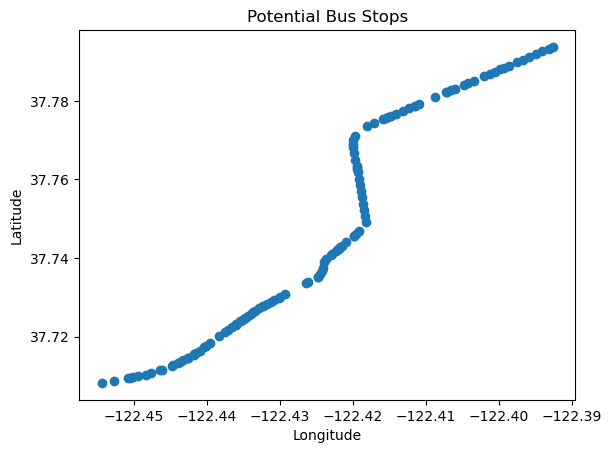

In [71]:
# Potential Bus Stops
plt.figure()
plt.scatter(bus_stops['Lng'], bus_stops['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Potential Bus Stops')

Text(0.5, 1.0, 'Employee Locations')

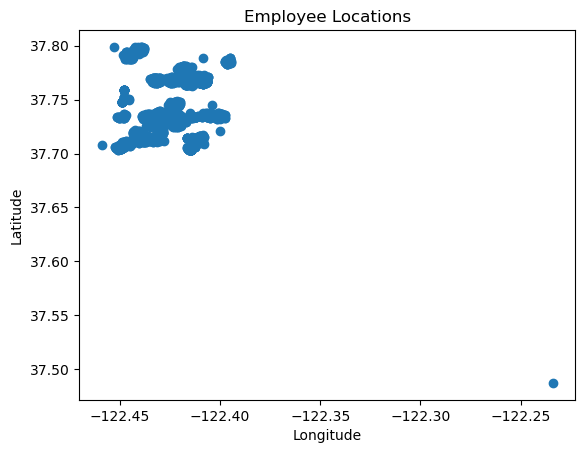

In [73]:
# Employee Addresses
plt.figure()
plt.scatter(addresses['Lng'], addresses['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Employee Locations')

### Data Cleaning

In [74]:
addresses[addresses['Lat']<37.5]

,address,employee_id,Lng,Lat
1774,"275 Perry St, San Francisco, CA 94107, USA",860,-122.23414,37.48708


From looking at the scatterplot of the employee addresses, we can see that there is an outlier at roughly 37.49 Latitude and -122.23 Longitude. We can drop it and re-draw the plot.

In [87]:
addresses = addresses[addresses['Lat']>37.5]

Text(0.5, 1.0, 'Employee Locations')

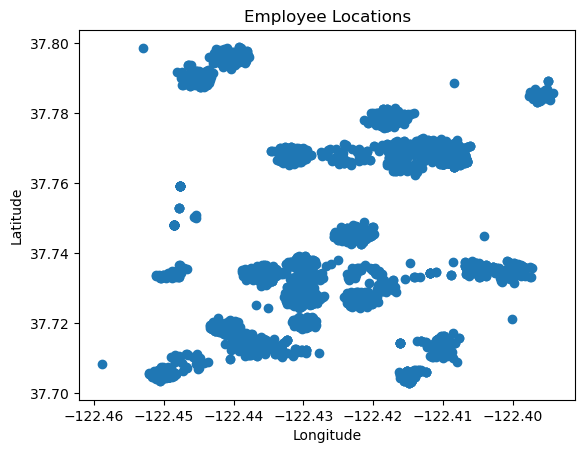

In [88]:
# Employee Addresses
plt.figure()
plt.scatter(addresses['Lng'], addresses['Lat'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Employee Locations')

In [89]:
# Save the geocoded addresses to a CSV file so we don't need to re-run the geocoder
bus_stops.to_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Potential_Bus_Stops_Geocoded.csv', encoding='utf-8')
addresses.to_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Employee_Addresses_Geocoded.csv', encoding='utf-8')

### K-Means Clustering

In [94]:
Potential_Bus_Stops = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Potential_Bus_Stops_Geocoded.csv')
Potential_Bus_Stops = Potential_Bus_Stops.drop(Potential_Bus_Stops.columns[0], axis=1)
Potential_Bus_Stops.head()

,Street_One,Street_Two,complete_bus_stops,Lng,Lat
0,MISSION ST,ITALY AVE,"MISSION ST & ITALY AVE SAN FRANCISCO, CA",-122.43953,37.71847
1,MISSION ST,NEW MONTGOMERY ST,"MISSION ST & NEW MONTGOMERY ST SAN FRANCISCO, CA",-122.40050,37.78745
2,MISSION ST,1ST ST,"MISSION ST & 1ST ST SAN FRANCISCO, CA",-122.39757,37.78978
3,MISSION ST,20TH ST,"MISSION ST & 20TH ST SAN FRANCISCO, CA",-122.41904,37.75863
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA",-122.39669,37.79047


In [93]:
Employee_Addresses = pd.read_csv('C:/Sophia/School!!!/2023 Spring 1/DS take home/14.shuttle_stops/Employee_Addresses_Geocoded.csv')
Employee_Addresses = Employee_Addresses.drop(Employee_Addresses.columns[0], axis=1)
Employee_Addresses.head()

,address,employee_id,Lng,Lat
0,"98 Edinburgh St, San Francisco, CA 94112, USA",206,-122.42719,37.72757
1,"237 Accacia St, Daly City, CA 94014, USA",2081,-122.41611,37.70426
2,"1835 Folsom St, San Francisco, CA 94103, USA",178,-122.41508,37.76778
3,"170 Cambridge St, San Francisco, CA 94134, USA",50,-122.41945,37.72964
4,"16 Roanoke St, San Francisco, CA 94131, USA",1863,-122.43110,37.73639


In [95]:
from sklearn.cluster import KMeans

# Employee address data in longitude/latitude
X = np.array(list(zip(Employee_Addresses['Lng'], Employee_Addresses['Lat'])))
X

array([[-122.42719,   37.72757],
       [-122.41611,   37.70426],
       [-122.41508,   37.76778],
       ...,
       [-122.41714,   37.73101],
       [-122.42965,   37.71231],
       [-122.41396,   37.76231]])

In [96]:
kmeans = KMeans(n_clusters=10, random_state=42).fit(X)
cluster_centers = kmeans.cluster_centers_
cluster_centers

array([[-122.42898496,   37.72824841],
       [-122.4435179 ,   37.79248662],
       [-122.4133566 ,   37.76994653],
       [-122.44181854,   37.7119916 ],
       [-122.41269898,   37.70956393],
       [-122.4252654 ,   37.74002432],
       [-122.39618535,   37.78537372],
       [-122.40370551,   37.73494757],
       [-122.44844707,   37.74446267],
       [-122.4299791 ,   37.7679806 ]])

In [97]:
clstr_lng_list, clstr_lat_list = zip(*cluster_centers)

In [99]:
# Potential bus stops
stops = np.array(Potential_Bus_Stops.loc[:, ['Lng', 'Lat']])
print('Potential Bus Stops\n', stops)
print()
print('Cluster Centers:\n', cluster_centers)

Potential Bus Stops
 [[-122.43953   37.71847]
 [-122.4005    37.78745]
 [-122.39757   37.78978]
 [-122.41904   37.75863]
 [-122.39669   37.79047]
 [-122.41998   37.76998]
 [-122.42004   37.76907]
 [-122.39584   37.79116]
 [-122.41987   37.74559]
 [-122.42612   37.73395]
 [-122.44013   37.71766]
 [-122.39933   37.78838]
 [-122.40483   37.78405]
 [-122.43128   37.72874]
 [-122.44265   37.71461]
 [-122.42196   37.74239]
 [-122.39497   37.79186]
 [-122.42925   37.73078]
 [-122.41982   37.76667]
 [-122.42238   37.74175]
 [-122.43178   37.72824]
 [-122.43234   37.72772]
 [-122.42423   37.73664]
 [-122.45052   37.70955]
 [-122.39319   37.79325]
 [-122.45443   37.70821]
 [-122.41946   37.76272]
 [-122.39979   37.78801]
 [-122.40717   37.78219]
 [-122.441     37.71639]
 [-122.42284   37.74101]
 [-122.41874   37.75545]
 [-122.40869   37.78098]
 [-122.41912   37.74676]
 [-122.4195    37.76342]
 [-122.4308    37.72924]
 [-122.44265   37.71461]
 [-122.41814   37.74906]
 [-122.4215    37.74315]
 [-1

In [100]:
from sklearn.metrics.pairwise import euclidean_distances  # L2 distance
from sklearn.metrics.pairwise import manhattan_distances  # L1 distance

stop_index_l1 = []
stop_index_l2 = []

# For each centroid, find the distances to every bus stop and return the closest stop
for centroid in cluster_centers:
    distances_l1 = [manhattan_distances(centroid.reshape(1, -1), stop.reshape(1, -1)) for stop in stops]
    distances_l2 = [euclidean_distances(centroid.reshape(1, -1), stop.reshape(1, -1)) for stop in stops]
    stop_index_l1.append(np.argmin(distances_l1))
    stop_index_l2.append(np.argmin(distances_l2))
    
print('Indexes of closest stops to centroids with L1 distance:', stop_index_l1)
print('Indexes of closest stops to centroids with L2 distance:', stop_index_l2)

Indexes of closest stops to centroids with L1 distance: [62, 76, 5, 48, 48, 95, 4, 78, 55, 66]
Indexes of closest stops to centroids with L2 distance: [62, 76, 50, 67, 20, 95, 73, 8, 21, 6]


In [102]:
# Names of bus stops using K-Means and Manhattan distance (L1)
Potential_Bus_Stops.loc[stop_index_l1]

,Street_One,Street_Two,complete_bus_stops,Lng,Lat
62,MISSION ST,ADMIRAL AVE,"MISSION ST & ADMIRAL AVE SAN FRANCISCO, CA",-122.43015,37.72986
76,MISSION ST,LAFAYETTE ST,"MISSION ST & LAFAYETTE ST SAN FRANCISCO, CA",-122.41808,37.77352
5,MISSION ST,13TH ST,"MISSION ST & 13TH ST SAN FRANCISCO, CA",-122.41998,37.76998
48,MISSION ST,POPE ST,"MISSION ST & POPE ST SAN FRANCISCO, CA",-122.44183,37.71543
48,MISSION ST,POPE ST,"MISSION ST & POPE ST SAN FRANCISCO, CA",-122.44183,37.71543
95,MISSION ST,RANDALL ST,"MISSION ST & RANDALL ST SAN FRANCISCO, CA",-122.42362,37.73980
4,MISSION ST,FREMONT ST,"MISSION ST & FREMONT ST SAN FRANCISCO, CA",-122.39669,37.79047
78,MISSION ST,COLLEGE AVE,"MISSION ST & COLLEGE AVE SAN FRANCISCO, CA",-122.42481,37.73526
55,MISSION ST,29TH ST,"MISSION ST & 29TH ST SAN FRANCISCO, CA",-122.42092,37.74408
66,MISSION ST,14TH ST,"MISSION ST & 14TH ST SAN FRANCISCO, CA",-122.41997,37.76829


In [104]:
# Names of bus stops using K-Means and Euclidean distance (L2)
Potential_Bus_Stops.loc[stop_index_l2]

,Street_One,Street_Two,complete_bus_stops,Lng,Lat
62,MISSION ST,ADMIRAL AVE,"MISSION ST & ADMIRAL AVE SAN FRANCISCO, CA",-122.43015,37.72986
76,MISSION ST,LAFAYETTE ST,"MISSION ST & LAFAYETTE ST SAN FRANCISCO, CA",-122.41808,37.77352
50,MISSION ST,11TH ST,"MISSION ST & 11TH ST SAN FRANCISCO, CA",-122.41710,37.77433
67,MISSION ST,CONCORD ST,"MISSION ST & CONCORD ST SAN FRANCISCO, CA",-122.44334,37.71397
20,MISSION ST,TINGLEY ST,"MISSION ST & TINGLEY ST SAN FRANCISCO, CA",-122.43178,37.72824
95,MISSION ST,RANDALL ST,"MISSION ST & RANDALL ST SAN FRANCISCO, CA",-122.42362,37.73980
73,MISSION ST,SHAW ALY,"MISSION ST & SHAW ALY SAN FRANCISCO, CA",-122.39857,37.78898
8,MISSION ST,FAIR AVE,"MISSION ST & FAIR AVE SAN FRANCISCO, CA",-122.41987,37.74559
21,MISSION ST,THERESA ST,"MISSION ST & THERESA ST SAN FRANCISCO, CA",-122.43234,37.72772
6,MISSION ST,ERIE ST,"MISSION ST & ERIE ST SAN FRANCISCO, CA",-122.42004,37.76907
